<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
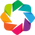

Initializing Julia interpreter. This may take some time...


In [1]:
if True: # enable folding code
    if False:
        from julia.api import Julia
        jl = Julia(compiled_modules=False)

    import julia; julia.install(quiet=True)
    from julia import Main

    import holoviews as hv; hv.extension('bokeh')
    import panel as pn; pn.extension()

    import itikz
    from itikz import nicematrix as nM

    import numpy as np
    import sympy as sp
    from IPython.display import display, Math

    np.set_printoptions(precision=3, suppress=True)

    try:
        from scipy.linalg import norm, inv, cholesky, eig, eigh, qz, ordqz
        HAVE_SCIPY = True
    except Exception as e:
        HAVE_SCIPY = False
        print("SciPy not available;", e)

%load_ext julia.magic

In [2]:
%%julia
using Pkg
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, BlockArrays, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

  Activating project at `C:\Users\jeff\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


In [3]:
%%julia
"""
    classify_gsvd(F; tol = 1e-12)

Given a GSVD factorization object `F` (as returned by `svd(A,B)`),
recover the number of
  • pure-A   (alpha=1, beta=0)
  • mixed    (0<alpha<1, 0<beta<1)
  • pure-B   (alpha=0, beta=1)
  • nullspace (alpha=0, beta=0)

using the LAPACK structural constraints:

  - indices 1:k       → pure-A
  - indices k+1:k+l   → mixed OR pure-B
  - indices > k+l     → nullspace

Returns a named tuple.
"""
function classify_gsvd(F; tol=1e-12, show=true)
    alpha = F.alpha
    beta  = F.beta
    k     = F.k               # pure-A
    l     = F.l               # mixed + pure-B
    N     = length(alpha)
    r     = k + l             # rank

    # index partitions
    pureA_idx = 1:k
    mid_idx   = k+1 : k+l
    null_idx  = k+l+1 : N

    # pure A = exactly the first k indices by LAPACK definition
    npureA = k

    # pure B: among mid block, (alpha ≈ 0, beta ≈ 1)
    npureB = count(i -> abs(alpha[i]) < tol && abs(beta[i] - 1) < tol, mid_idx)

    # mixed: remaining mid-block entries where both alpha, beta are nonzero
    nmixed = l - npureB

    # nullspace: trailing (0,0) entries
    nnull = count(i -> abs(alpha[i]) < tol && abs(beta[i]) < tol, null_idx)

    if show
        py_show( L"pureA = ",        npureA,
                 L",\;\; mixed = ",  nmixed,
                 L",\;\ pureB = ",   npureB,
                 L",\;\;n_0 = ",     nnull )
    end

    return (
        n_A  = npureA,
        n_M  = nmixed,
        n_B  = npureB,
        n_0  = nnull,
        rank = r,
        n    = N
    )
end

"""
    res = function gsvd(A,B)

utility function to augmment ths svd(routine) with additional information
returns
* res.F   the GSVD standard structure
* res.X   the domain basis matrix
* res.C   the C matrix augmented by the n_0 block  (size(C) == size(A))
* res.S   the S matrix augmented by the n_0 block  (size(S) == size(B))
* res.sz  the sizes of the subspaces (n_A, n_M, n_B, n_0) and the combined rank
"""
function naive_gsvd(A,B)
    F = svd(A, B)
    U,V,Q,C,S,R = F
    H = R*Q'

    N = nullspace([A; B])
    X = size(N, 2) == 0 ? pinv(H) : [pinv(H) N]

    sz = classify_gsvd(F; show=false)
    if sz.n_0 > 0
        C = [C zeros(size(C,1), sz.n_0)]
        S = [S zeros(size(S,1), sz.n_0)]
    end

    m_A,N  = size(A)
    m_B  = size(B,1)

    return (
        alpha=F.alpha, beta=F.beta,
        U=BlockArray(U, [m_A],       [sz.n_A, sz.n_M, size(U,2)-sz.n_A-sz.n_M]),
        V=BlockArray(V, [m_B],       [size(V,2)-sz.n_M-sz.n_B, sz.n_M, sz.n_B]),
        X=BlockArray(X, [size(A,2)], [sz.n_A, sz.n_M, sz.n_B, size(X,2)-sz.rank]),
        C=BlockArray(C, [m_A],       [sz.n_A, sz.n_M, size(S,2)-sz.n_A-sz.n_M, ]),
        S=BlockArray(S, [m_B],       [size(S,2)-sz.n_M-sz.n_B, sz.n_M, sz.n_B]),
        sz=sz
    )
end
function show( C::BlockArray, S::BlockArray, sz::NamedTuple; digits=2)
    function highlight_C(x, i, j, formatted; sz=sz)
        if 1 ≤ i ≤ sz.rank && i == j
            return "\\textcolor{red}{" * formatted * "}"
        else
            return formatted
        end
    end

    function highlight_S(x, i, j, formatted; sz=sz)
        if 1 ≤ i ≤ sz.n_M + sz.n_B && i + sz.n_A == j
            return "\\textcolor{red}{" * formatted * "}"
        else
            return formatted
        end
    end
    py_show( "C and S matrices", color="blue")
    py_show( L"C = ", (C, per_element_style=highlight_C), L",\quad S = ", (S, per_element_style=highlight_S), number_formatter=x->round(x,digits=digits))
end
function show_X_basis( A,B,res)
    c(A) = (m=A,color="red")
    sz=res.sz
    XA,XM,XB,X0 = res.X[:, 1:sz.n_A],
                  res.X[:,sz.n_A+1:sz.n_A+sz.n_M],
                  res.X[:,sz.n_A+sz.n_M+1:sz.n_A+sz.n_M+sz.n_B],
                  res.X[:,sz.n_A+sz.n_M+sz.n_B+1:end]
    py_show( "A X and B X", color="blue")

    if sz.n_A > 0 py_show(L"X_A = ", XA, L"\quad  A X_A = ",   A*XA,  L",\quad B X_A = ", c(B*XA), number_formatter=x->round_value(x,2)) end
    if sz.n_M > 0 py_show(L"X_M = ", XM, L"\quad  A X_M = ",   A*XM,  L",\quad B X_M = ",    B*XM, number_formatter=x->round_value(x,2)) end
    if sz.n_B > 0 py_show(L"X_B = ", XB, L"\quad  A X_B = ", c(A*XB), L",\quad B X_B = ",    B*XB, number_formatter=x->round_value(x,2)) end
    if sz.n_0 > 0 py_show(L"X_0 = ", X0, L"\quad  A X_0 = ", c(A*X0), L",\quad B X_0 = ", c(B*X0), number_formatter=x->round_value(x,2)) end
end
;

<div style="height:2cm;"></div>
<div style="float:center; width:100%; text-align:center;">
  <strong style="height:100px; color:darkred; font-size:40px;">
    The Generalized Singular Value Decomposition (GSVD)
  </strong>
</div>
<div></div>

# 1. Introduction

The generalized singular value decomposition (GSVD) extends the generalized eigenproblem (GEP)  
from square pencils to rectangular matrix pairs that act on the same parameter space.

In the GEP, a pair of **square matrices** $\; A\in\mathbb{R}^{n\times n}, B\in\mathbb{R}^{n\times n}$  
is reduced by two‑sided orthogonal transformations to generalized Schur form  
$\qquad A = Q_l\ S\ Q_r^T, \quad B = Q_l\ T\ Q_r^T$,

In the GSVD, a pair of **rectangular matrices**
$\; A\in\mathbb{R}^{m_A\times n}, B\in\mathbb{R}^{m_B\times n}$  
is reduced to structured forms  
$\qquad A = U\ C\ X^{-1}, \quad B = V\ S\ X^{-1},$  
with a common **invertible** right factor $Q\equiv X$ and separate **orthogonal** left factors $Q_a\equiv U, Q_b\equiv V$.

The price of this generalization is that the shared right basis matrix $X$ can no longer be chosen orthonormal in general.

**Remark:**
* The matrices $A$ and $B$ have the same number of columns.  
The linear transformations $y = A x$ and $y = B x$ have the same codomain with basis matrix $X$.
* The matrices $A$ and $B$ may have different number of rows  
The linear transformations $y = A x$ and $y = B x$ have domains with basis matrices $U$ and $V$ respectively.
* The GSVD derives basis matrices $U$, $V$ and $X$ to make the linear transformation matrices $C$ and $S$  
with respect to these bases have simple diagonal or block‑diagonal structure,  
enabling ready comparisons of the respective actions of these matrices.

____
In many applications the natural object is not a single matrix, but a pair of matrices $(A,B)$
acting on the same parameter vector $x$.

Typical examples include:
* **Regularized least squares.** Given data $b$, a forward model $A$ and a regularization operator $B$,
one solves  
$\qquad\displaystyle{\min_x\ \left(\ \Vert A x - b \Vert^2 + \lambda^2 \Vert B x \Vert^2
\ \right)
}$  
and wants to understand directions $x$ where the data misfit 
$\Vert A x - b \Vert$ and the penalty $\Vert B x \Vert$ trade off against each other.
* **Two views of the same samples.** In multiview learning rows of $A$ and $B$  
contain measurements of features for a particular sample,  
and the goal is to find patterns that are shared between the two views  
as well as patterns that are specific to just one.
* **Quotient and balance problems.** In stability, control, and discrimination tasks,  
one is interested in directions $x$
where a ratio such as $\;\;\displaystyle{\frac{\Vert A x \Vert }{ \Vert B x \Vert}
}$  
is large or small, i.e., where the action of $A$ dominates that of $B$. or vice versa.

All of these problems involve comparing how two linear transformations 
$A$ and $B$ act on the same $x$.

As detailed in the following notebooks on the GSVD, such comparisons can be formulated and analyzed  
in terms of the GSVD of the matrix pair $(A,B)$:  
it provides a shared set of directions $x_i$ and associated generalized singular values  
that quantify the relative effect of $A$ versus $B$ along each direction.

# 2. GSVD Matrix Decomposition Examples

## 2.1 Shape and Structure of the Matrices

In the generalized singular value decomposition of a matrix pair $(A,B)$, the matrices  
$\qquad
C = U^T A X, \qquad S = V^T B X,
$

represent $A$ and $B$ in the coordinate systems determined by the orthogonal matrices $U$, $V$, and the invertible matrix $X$.  
Within the nonzero blocks of $C$ and $S$ there are $r = \operatorname{rank}\!\begin{pmatrix}A\\B\end{pmatrix}$ nonnegative pairs $(c_i,s_i)$   
arranged along the block diagonals, satisfying $c_i^2 + s_i^2 = 1$;  
all other entries of $C$ and $S$ are zero.  

Each such pair defines a generalized singular direction and falls into one of four structurally distinct categories:
- **pure-A:** $\qquad\qquad\qquad (c_i,s_i) = (1,0)$, contributing only to $A$
- **mixed:** $\;\;\qquad\qquad\qquad 0 < c_i < 1$ and $0 < s_i < 1$, contributing simultaneously to both $A$ and $B$
- **pure-B:** $\qquad\qquad\qquad(c_i,s_i) = (0,1)$, contributing only to $B$
- **common null space:** $\;\;(c_i,s_i) = (0,0)$, representing directions annihilated by both $A$ and $B$.

The GSVD orders these cases canonically: pure-A first, then mixed and pure-B directions,  
followed by any common-nullspace directions  
so that the block structure of $C$ and $S$ makes the roles of these four types of directions explicit.

### 2.1.1 Block Structure of C and S

Let
- $n_A$ = number of pure-A directions $(c_i,s_i)=(1,0)$
- $n_M$ = number of mixed directions $(0<c_i<1,\,0<s_i<1)$
- $n_B$ = number of pure-B directions $(c_i,s_i)=(0,1)$
- $n_0$ = number of common-nullspace directions $(c_i,s_i)=(0,0)$, so that

The matrices $C$ and $S$, (i.e., the representations of $A$ and $B$  
in the coordinate systems $U, X$ for matrix $A$ and $V, X$, for matrix $B$), take the form

$\qquad C =
\left(
\begin{array}{ll|l}
I_{n_A} & 0            & 0  \\
0       & \tilde{C}_{n_M}          & 0  \\
0       & 0            & 0_{n_B+n_0}  \\
\end{array}
\right)
\qquad S =
\left(\begin{array}{l|ll}
0       & \tilde{S}_{n_M}      & 0  & 0\\
0       & 0        & I_{n_B}  & 0\\
0_{n_A}       & 0        & 0 & 0_{n_0} \\
\end{array}\right).
$

The subscipts are the sizes of the columns. The $\tilde{C}$ and $\tilde{S}$ matrices are triangular.  
Their diagonal entries satisfy $0 < c_i < 1$ and $0 < s_i < 1$, with $c_i^2+s_i^2 =1 $.

### 2.1.2 Bases of the Subspaces

Partition the columns of $X = \left(\begin{array}{cccc} X_A & X_M & X_B & X_0 \end{array}\right),\;$
with successive block widths $n_A, n_M, n_B$ and $n_0$,  
and consider the resulting submatrix products in $A X = U C$ and $B X = V C$

<div style="float:left;">
  <div style="text-align: right;">
    <div style="padding-bottom:0.5cm;"><strong>Partitioning A X = U C </strong></div>
    <img src="Figs/gsvd_C.svg" alt="gsvd_C">
  </div>
</div>
<div style="float:left;padding-left:2cm">
  <div style="text-align: right;">
    <div style="padding-bottom:0.5cm;"><strong>Partitioning B X = V S </strong></div>
    <img src="Figs/gsvd_S.svg" alt="gsvd_S">
  </div>
</div>


<div style="float:left;padding-left:2cm;">

| $A X = U C\qquad\qquad$ | $B X = V S\qquad\qquad$| Domain and Codomain Base Matrices | Subspace Characterization |
| :----                   | :----                        | ---- | ----:|
| $A X_A = U_A$           | $B X_A = 0$                  | $X_A,$ and $U_A,V_A$ for  $(c_i,s_i)=(1,0)$|**A-only subspaces** |
| $A X_M = U_M \tilde{C}$ | $B X_M = V_M \tilde{S}$    | $X_M,$ and $U_M,V_M$ for  mixed $(c_i,s_i)$|**mixed subspaces**|
| $A X_B = 0$             | $B X_B = V_B$                  | $X_B,$ and $U_B,V_B$ for $(c_i,s_i)=(0,1)$|**B-only subspaces** |
| $A X_0 = 0$             | $B X_0 = 0$                  | $X_0,$ and $U_0,V_0$ for $(c_i,s_i)=(0,0)$|$\quad$ **common right-null spaces**|
</div>

## 2.2 Example Decompositions

### Mixed Subspaces Only  $n_M=1, n_A=n_B=n_0=0$

In [4]:
%%julia
diagonal_highlight = (x, i, j, formatted) -> i == j ? "\\textcolor{red}{" * formatted * "}" : formatted

function example_mixed_only()
    # Both A and B full column rank, no pure A/B directions
    A = randn(4, 3)
    B = randn(5, 3)
    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))

    res = naive_gsvd(A,B)

    println("sizes:  ", res.sz)
    py_show( L"X = ", res.X, L",\quad U = ", res.U, L",\quad V = ", res.V, number_formatter=x->round(x,digits=2))
    show(res.C, res.S, res.sz)
    show_X_basis(A,B,res)
    return res
end
_=example_mixed_only();

<IPython.core.display.Latex object>

sizes:  (n_A = 0, n_M = 3, n_B = 0, n_0 = 0, rank = 3, n = 3)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Example $n_A=1, n_M=1, n_B=0, n_0=0$

In [5]:
%%julia
function example_pureA_pureB_mixed()
    A = [
        3.0  0.1  1.0;
        0.0  0.5  0.5;
        0.0  0.0  0.0;
    ]

    B = [
        0.0  2.5  1.0;
        0.0  0.0  0.5;
        0.0  0.3  0.0;
        0.0  0.0  0.0;
        0.0  0.0  0.0
    ]

    res = naive_gsvd(A,B)

    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))
    py_show( L"X = ", res.X, L",\quad U = ", res.U, L",\quad V = ", res.V, number_formatter=x->round(x,digits=2))
    show(res.C, res.S, res.sz, digits=3)
    show_X_basis(A,B,res)
    return res
end
_ = example_pureA_pureB_mixed();

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Example: Common nullspace $n_A = 0, n_M = 3, n_B = 0, n_0 = 1$

In [6]:
%%julia
function example_larger_mixed()
    A = [
        2.0  0.5  0.0  2.5;
        0.0  1.5  0.5  2.0;
        0.0  0.0  1.0  1.0;
        1.0  0.0  0.0  1.0
    ]

    B = [
        0.5  2.0  0.0  2.5;
        0.0  0.5  1.5  2.0;
        0.0  0.0  1.0  1.0;
        0.0  0.0  0.0  0.0
    ]

    res = naive_gsvd(A,B)

    py_show(L"A \approx ", A, L",\qquad B \approx ", B, number_formatter=x->round(x,digits=3))

    println("sizes:  ", res.sz)
    py_show( L"X = ", res.X, L",\quad U = ", res.U, L",\quad V = ", res.V, number_formatter=x->round(x,digits=2))
    show(res.C, res.S, res.sz, digits=3)
    show_X_basis(A,B,res)
end
_ = example_larger_mixed();

<IPython.core.display.Latex object>


(n_A = 0, n_M = 3, n_B = 0, n_0 = 1, rank = 3, n = 4)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

paig-saunder 

# Temporary STUFF

In [ ]:
import itikz
from itikz import nicematrix as nM

lC = [[ "I", "0", "0"],["0", "\\tilde{C}", "0"],[ "0", "0", "0"]]
lU = [["U_A", "U_M", "U_0"]]
lUC = [["U_A", "U_M \\tilde{C}", "0"]]

layers=[ [None, lC], [lU, lUC]]
h,m = nM.ge( layers, Nrhs=[0],
             formater = lambda x:x,
             tmp_dir="tmp", keep_file="tmp/gsvd_C"
)
h

In [ ]:
lS =[["0", "\\tilde{S}", "0", "0"],[ "0", "0", "I", "0"],[ "0", "0", "0", "0" ]]

lV = [["V_0", "V_M", "V_B"]]
lVS = [["0", "V_M \\tilde{S}", "V_B", "0"]]

layers=[ [None, lS], [lV, lVS]]
h,m = nM.ge( layers, Nrhs=[0],
             formater = lambda x:x,
             tmp_dir="tmp", keep_file="tmp/gsvd_S"
)
h